In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import pyforest
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',1000)

In [2]:
loan=pd.read_csv('loan.csv')
loan1=loan.copy()
# impute gender with most freq category
loan1['Gender']=loan1['Gender'].fillna('Male')
# impute gender with most freq category
loan1['Dependents']=loan1['Dependents'].fillna('0')
# impute gender with most freq category
loan1['Self_Employed']=loan1['Self_Employed'].fillna('No')
# as the distribution is skewed, we'll do for median imputation
loan1['LoanAmount']=loan1['LoanAmount'].fillna(loan1['LoanAmount'].median())
# we'll do for mean imputation
loan1['Loan_Amount_Term']=loan1['Loan_Amount_Term'].fillna(loan1['Loan_Amount_Term'].mean())
# impute gender with most freq category
loan1['Credit_History']=loan1['Credit_History'].fillna(1.0)
# impute gender with most freq category
loan1['Married']=loan1['Married'].fillna('Yes')
# drop loanid
loan1.drop('Loan_ID',axis=1,inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder
def le(df,col):
    lab=LabelEncoder()
    df[col]=pd.Series(lab.fit_transform(df[col]))

In [4]:
le(loan1,'Gender')
le(loan1,'Married')
le(loan1,'Dependents')
le(loan1,'Education')
le(loan1,'Self_Employed')
le(loan1,'Property_Area')
le(loan1,'Loan_Status')

In [5]:
from scipy.stats import zscore
z=np.abs(zscore(loan1))
loan1=loan1[(z<3).all(axis=1)]

x=loan1.drop('Loan_Status',axis=1)
y=loan1['Loan_Status']

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
from sklearn.metrics import roc_curve, roc_auc_score

# Now, let's define some functions to reuse them
def fitc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    
def get_scorec(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    train_score=m.score(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return train_score,test_score

def get_predc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    return pred

def get_metricsc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    acc=accuracy_score(pred,y_test)
    conf=confusion_matrix(pred,y_test)
    clas=classification_report(pred,y_test)
    return acc,conf,clas

from sklearn.model_selection import GridSearchCV
def gridcvc(m,p,x,y):
    gkb=GridSearchCV(m,p,n_jobs=-1,cv=5,scoring='accuracy')
    gkb.fit(x,y)
    return gkb.best_params_


from sklearn.model_selection import RandomizedSearchCV
def randomcvc(m,p,x,y):
    from sklearn.model_selection import RandomizedSearchCV
    gkb=RandomizedSearchCV(estimator=m,param_distributions=p,
                          cv=5,n_iter=75,
                          n_jobs=-1, verbose=5,return_train_score=True,random_state=45)
    gkb.fit(x,y)
    return gkb.best_params_

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
def bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    return xbfe

def ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    return xffs

from sklearn.decomposition import PCA
def nforpcac(x):
    pca=PCA().fit(x)
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
    plt.xlabel('No of Components')
    plt.ylabel('Variance')
    plt.axhline(y=95, color='r', linestyle='--')
    plt.show()
    
def pcac(m,x,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    return xpca

def crossc(m,x,y,c=5):
    score=cross_val_score(m,x,y,cv=c,n_jobs=-1)
    return (score.mean(), score.std())

from sklearn.preprocessing import StandardScaler
def stdc(x):
    scx=StandardScaler()
    xs=pd.DataFrame(scx.fit_transform(x), columns=x.columns)
    return xs

from sklearn.preprocessing import MinMaxScaler
def mmc(x):
    mm=MinMaxScaler()
    xm=pd.DataFrame(mm.fit_transform(x), columns=x.columns)
    return xm

def modified_bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xbfe,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xffs,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_pcac(m,x,y,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    x_train, x_test, y_train, y_test=train_test_split(xpca,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def ttsc(x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    return x_train, x_test, y_train, y_test

def classification(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    clas=classification_report(pred,y_test)
    return clas

lrc=LogisticRegression(n_jobs=-1,random_state=45)
dtc=DecisionTreeClassifier(random_state=45)
svc=SVC(random_state=45)
knnc=KNeighborsClassifier(n_jobs=-1)
rfc=RandomForestClassifier(n_jobs=-1,random_state=45)
gbc=GradientBoostingClassifier(random_state=45)
xgbc=XGBClassifier(n_jobs=-1,random_state=45)
adac=AdaBoostClassifier(random_state=45)
gnb=GaussianNB()
mnb=MultinomialNB()

In [7]:
xs=stdc(x)
x_sk=x.copy()

# x_sk['ApplicantIncome'].min(), x_sk['ApplicantIncome'].max()
x_sk['ApplicantIncome']=np.log(x_sk['ApplicantIncome'])
# skewness reduced to -0.20
# x_sk['CoapplicantIncome'].min(), x_sk['CoapplicantIncome'].max()
x_sk['CoapplicantIncome']=np.cbrt(x_sk['CoapplicantIncome'])
# skewness reduced to -0.03
# x_sk['LoanAmount'].min(), x_sk['LoanAmount'].max()
x_sk['LoanAmount']=np.cbrt(x_sk['LoanAmount'])
# skewness reduced to 0.05
# x_sk['Loan_Amount_Term'].min(), x_sk['Loan_Amount_Term'].max()
x_sk['Loan_Amount_Term']=np.power(x_sk['Loan_Amount_Term'],2.5)
# skewness reduced to 0.05
# x_sk['Dependents'].min(), x_sk['Dependents'].max()
x_sk['Dependents']=np.power(x_sk['Dependents'],1/5)
# skewness reduced to 0.43

xs_sk=stdc(x_sk)

# SVC

In [8]:
# SVC with xs_sk 0.8287037037037037, 0.8206896551724138

In [9]:
# svc=SVC(random_state=45)

In [10]:
# Individual Model Pipeline:
# 1. feature selection
# 2. Hyper parameter tuning
# 3. Boosting
# 4. Cross Validation
# 5. Evaluation Metrics

In [11]:
# lets apply BFE
# there are 11 features
for i in range(7,12):
    print(i," ",modified_bfec(svc,xs_sk,y,i))

7   0.8206896551724138
8   0.8206896551724138
9   0.8206896551724138
10   0.8137931034482758
11   0.8206896551724138


In [12]:
# same score

In [15]:
# PCA
# take n from 8 to 12
for i in range(4,12):
        print(i," ",modified_pcac(svc,xs_sk,y,i))

4   0.696551724137931
5   0.8137931034482758
6   0.8275862068965517
7   0.8275862068965517
8   0.8206896551724138
9   0.8206896551724138
10   0.8206896551724138
11   0.8206896551724138


In [16]:
# score improved at n=6

In [17]:
xs_sk_pca1=pcac(svc,xs_sk,6)
xs_sk_pca1.head()

,0,1,2,3,4,5
0,1.227175,-1.113400,0.018509,-1.160499,0.113337,-0.398881
1,-1.268810,0.172314,-0.644767,0.077452,-0.586020,0.509644
2,0.608742,-0.477596,1.150413,-0.665461,-0.339994,0.252416
3,-0.316439,1.819031,0.364437,-0.207288,-0.134438,0.084346
4,1.125210,-1.227313,-0.068878,-1.131409,0.148618,-0.421022


In [18]:
get_scorec(svc,xs_sk_pca1,y)

(0.8310185185185185, 0.8275862068965517)

In [19]:
# lets tune the model

In [20]:
SVC?

In [21]:
param_svc={'kernel':['rbf','poly']}
randomcvc(svc,param_svc,xs_sk_pca1,y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


{'kernel': 'rbf'}

In [22]:
svc1=SVC(random_state=45,kernel='rbf',probability=True)

In [23]:
param_svc1={'C':[0.01,0.05,0.1,0.5,1,1.5,2,2.5]}
randomcvc(svc1,param_svc1,xs_sk_pca1,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.8s finished


{'C': 1}

In [25]:
param_svc2={'C':[0.6,0.7,0.8,0.9,1]}
randomcvc(svc1,param_svc2,xs_sk_pca1,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.3s finished


{'C': 0.8}

In [26]:
svc2=SVC(random_state=45,kernel='rbf',probability=True,C=0.8)
get_scorec(svc2,xs_sk_pca1,y)

(0.8240740740740741, 0.8206896551724138)

In [27]:
# score reduced

In [33]:
# lets boost svc,xs_sk_pca1,y
adasvc=AdaBoostClassifier(random_state=45,base_estimator=svc1,n_estimators=300,learning_rate=0.001)
get_scorec(adasvc,xs_sk_pca1,y)

(0.8263888888888888, 0.8275862068965517)

In [34]:
# the score is not improving

In [35]:
# lets cross validate svc,xs_sk_pca1,y
for i in range(2,13):
    print(i," ",crossc(svc1,xs_sk_pca1,y,i))

2   (0.8180687716262975, 0.025681228373702403)
3   (0.8181103003011149, 0.018663503581362217)
4   (0.8215957653457654, 0.026239878687864544)
5   (0.8181659170414791, 0.032067704240564626)
6   (0.8215690374992463, 0.032104764005158486)
7   (0.8182638930998223, 0.041003094533281895)
8   (0.8182161366218621, 0.04166465468695646)
9   (0.8198391500474833, 0.046464860948615586)
10   (0.8181715063520872, 0.04133157873060615)
11   (0.8197761358138717, 0.04402713473696293)
12   (0.8179812261784146, 0.043525884623034305)


In [36]:
# no over fitting or under fitting

In [37]:
# lets check metrics of lrc2, xs_sk ,y
# Evaluation metrics
acc, conf, clas=get_metricsc(svc1,xs_sk_pca1,y)
print(acc)
print(' ')
print(conf)
print(' ')
print(clas)

0.8275862068965517
 
[[21  1]
 [24 99]]
 
              precision    recall  f1-score   support

           0       0.47      0.95      0.63        22
           1       0.99      0.80      0.89       123

    accuracy                           0.83       145
   macro avg       0.73      0.88      0.76       145
weighted avg       0.91      0.83      0.85       145



In [38]:
# precision is not good

In [39]:
# auc roc

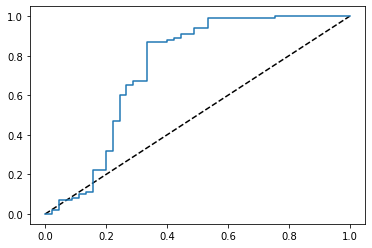

In [41]:
xtr,xte,ytr,yte=ttsc(xs_sk_pca1,y)
svc1.fit(xtr,ytr)
y_pred_pro=svc1.predict_proba(xte)[:,1]
fpr,tpr,threshold=roc_curve(yte,y_pred_pro)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr,tpr,label='LRC')
plt.show()

In [42]:
roc_auc_score(yte,y_pred_pro)

0.7388888888888889